# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [1]:
# @TODO: evaluation, BLEU, https://github.com/tylin/coco-caption

# @TODO: visualize attention (images) 
# @TODO: visualize self-attention (text) https://github.com/jessevig/bertviz
# @TODO: colorize sentence confidence

# @TODO: look at embedding space for some words (visualize with t-SNE, PCA or UMAP)


# @TODO: use larger encoder model (ViT-B/32, ViT-L/32, ViT-H/14) with 1024 hidden size
# @TODO: multiple transformer layers in the decoder (increase nheads, hidden size)
# @TODO: embedding (pre-trained?)


# @TODO: custom teacher forcing module, drop-in for GRU, LSTM, transformer(?): TeacherForcing(nn.GRU(), teachingRatio=.5)
# @TODO: compare against GPT-4 (with images) if possible

# references: https://arxiv.org/pdf/1711.08195v3.pdf, https://arxiv.org/pdf/2209.15323.pdf

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models import vgg19, vit_b_16, ViT_B_16_Weights

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza
stanza.download("en")

from utils import *
from dataset import *
from plots import *
from models import *

fix_seed()

c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
10:55:20 - INFO: Downloading default packages for language: en (English) ...
10:55:22 - INFO: File exists: C:\Users\rasmu\stanza_resources\en\default.zip
10:55:26 - INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.


## Load data

Let's load the metadata and the images.

In [4]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [5]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

10:55:27 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR1_1_IM-0001-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [6]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR1_1_IM-0001-3001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,CXR1_1_IM-0001-4001.png,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,CXR10_IM-0002-1001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
3,CXR10_IM-0002-2001.png,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
4,CXR100_IM-0002-1001.png,None.,None,Both lungs are clear and expanded. Heart and m...,No active disease.


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [7]:
reports = prepare_reports(metadata)
reports.head()

10:55:30 - INFO: raw report length: 7470
10:55:30 - INFO: post-processing report length: 7430


0    The cardiac silhouette and mediastinum size ar...
1    The cardiac silhouette and mediastinum size ar...
2    The cardiomediastinal silhouette is within nor...
3    The cardiomediastinal silhouette is within nor...
4    Both lungs are clear and expanded. Heart and m...
Name: report, dtype: object

In [8]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 256x256. 

In [9]:
# we'll only use a subset of the dataset in the *notebook* due to memory constraints. However, the scripts will use the full dataset.
N = 1000

metadata_subset = metadata[:N]
reports_subset = prepare_reports(metadata_subset)

images = load_images(metadata_subset, IMAGE_PATH, resized=(224, 224))
images = images[reports_subset.index]

10:55:31 - INFO: raw report length: 1000
10:55:31 - INFO: post-processing report length: 992


There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

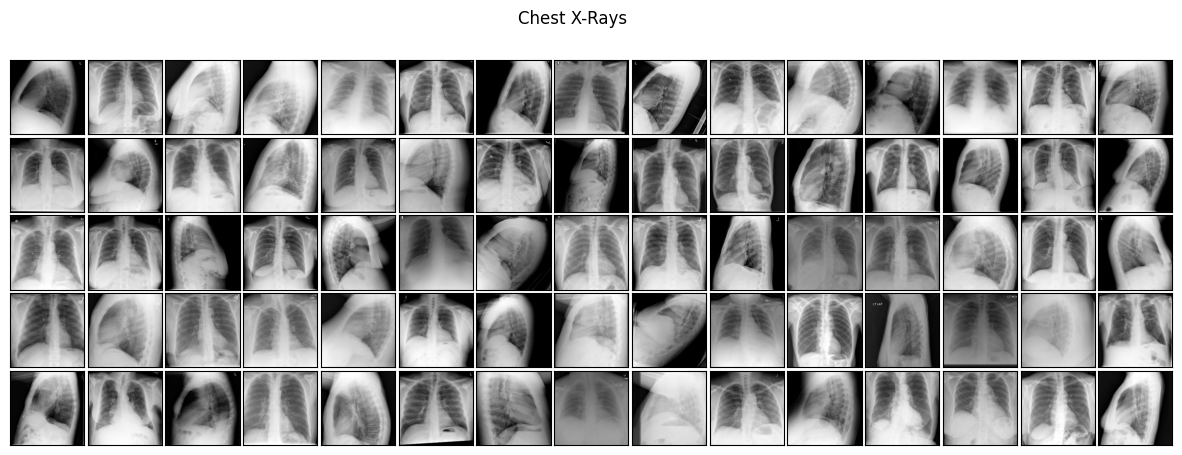

In [10]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

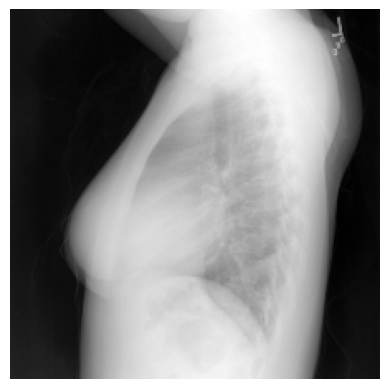

In [11]:
highlighted_image = images[0]
plot_image(highlighted_image)

Time to plot a few random X-ray image and their corresponding reports!

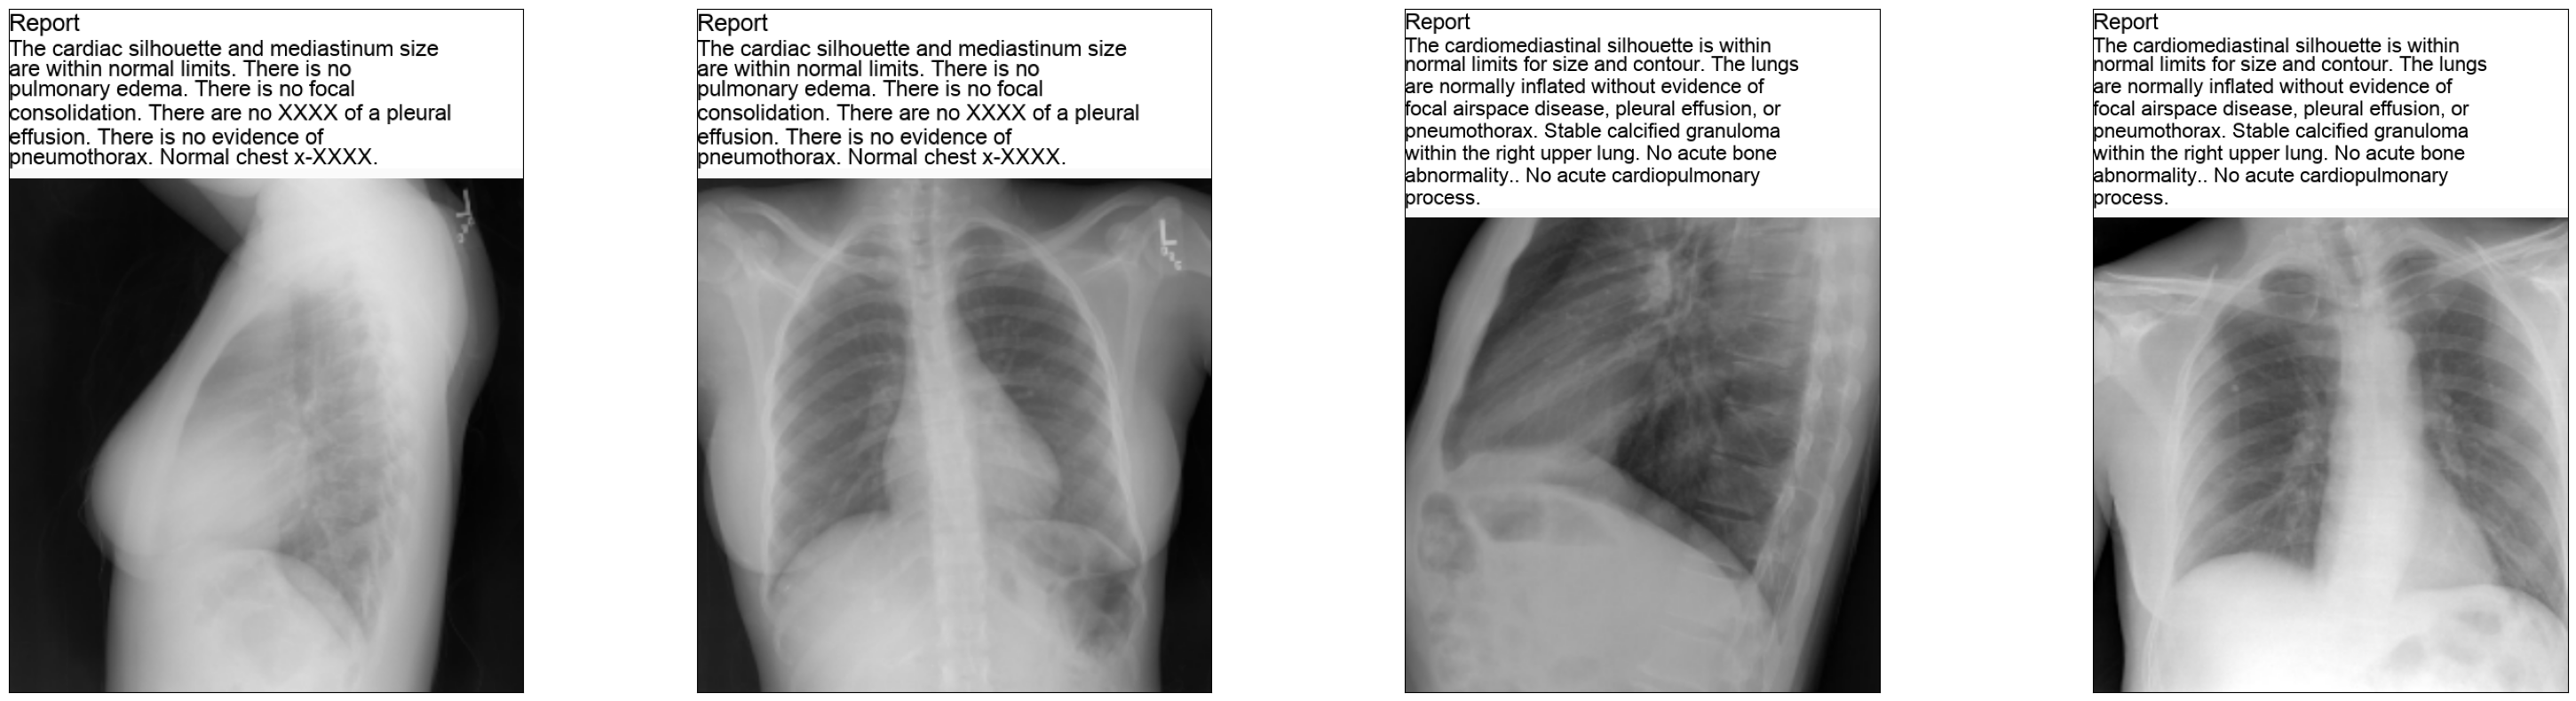

In [12]:
k = np.arange(4) #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = images[k].numpy()

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

### Images

Images are already normalized the range [0, 1]. The models may also do some more prepocessing of the images as some of them are pretrained model. Preprocessing includes z-score normalization. 

### Text

Let's tokenize the reports.

In [13]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

10:55:40 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
10:55:40 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

10:55:40 - INFO: Using device: cpu
10:55:40 - INFO: Loading: tokenize
10:55:40 - INFO: Done loading processors!


And time for some statistics:

In [14]:
tokenized_reports.head()

0    [the, cardiac, silhouette, and, mediastinum, s...
1    [the, cardiac, silhouette, and, mediastinum, s...
2    [the, cardiomediastinal, silhouette, is, withi...
3    [the, cardiomediastinal, silhouette, is, withi...
4    [both, lungs, are, clear, and, expanded, ., he...
Name: report, dtype: object

In [15]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 43.4 +- 21.7 words.
Report length boundaries: [3.0; 255.0] words.


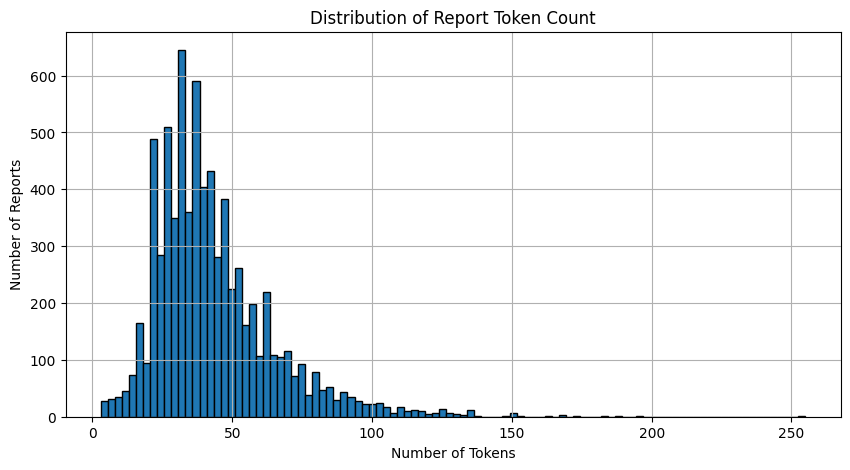

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

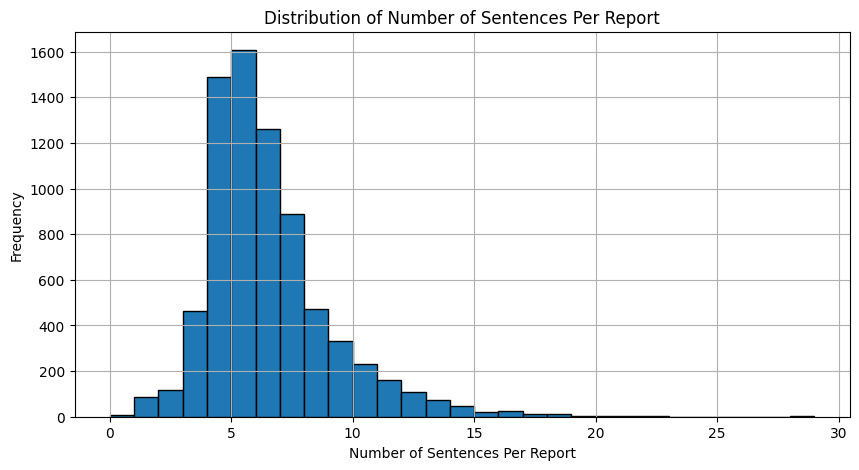

In [17]:
sentences = []
for token_ids in tokenized_reports:
    n_sentences = np.sum([1 for token in token_ids if token == "."])
    sentences.append(n_sentences)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentences, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Number of Sentences Per Report")
ax.set_xlabel("Number of Sentences Per Report")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

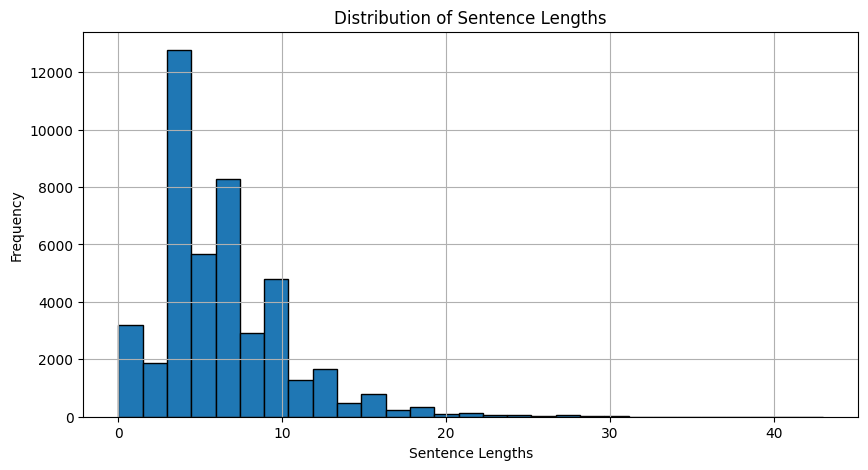

In [18]:
sentence_lengths = []
for token_ids in tokenized_reports:
    sentence_length = 0
    for token in token_ids:
        if token == ".":
            sentence_lengths.append(sentence_length)
            sentence_length = 0
        else:
            sentence_length += 1


fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentence_lengths, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Sentence Lengths")
ax.set_xlabel("Sentence Lengths")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

In [19]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id_fn(vocabulary)

vocabulary size: 1933 tokens


## Models

In [54]:
#model_name = "playground"
#model = XRayPlaygroundModel(len(vocabulary))

model_name = "vit"
model = XRayViTModel(len(vocabulary))

images_ready = model.encoder.preprocess(images)

train_test_split = .9
train_validation_split = .9

total_train_size = int(len(images) * train_test_split)
train_size = int(total_train_size * train_validation_split)

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:total_train_size], tokenized_reports[train_size:total_train_size], token2id)
test_dataset = XRayDataset(images_ready[total_train_size:], tokenized_reports[total_train_size:], token2id)

c:\Users\rasmu\anaconda3\envs\xray\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [48]:
train(model_name, model, vocabulary, train_dataset, validation_dataset, epochs=30, batch_size=32, lr=1e-3, weight_decay=0)

result_path = os.path.join("results", model_name, "result.pkl")
result = load_dict(result_path)
result["test_loss"] = evaluate(model, test_dataset, token2id)
save_dict(result, result_path)

100%|██████████| 3/3 [00:00<00:00, 11.38it/s]


Epoch 1 train loss: 7.577, validation loss: 7.530


100%|██████████| 3/3 [00:00<00:00, 12.74it/s]


Epoch 2 train loss: 7.486, validation loss: 7.425


100%|██████████| 3/3 [00:00<00:00, 12.21it/s]


Epoch 3 train loss: 7.382, validation loss: 7.307


100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


Epoch 4 train loss: 7.260, validation loss: 7.169


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


Epoch 5 train loss: 7.121, validation loss: 7.001


100%|██████████| 3/3 [00:00<00:00, 11.43it/s]


Epoch 6 train loss: 6.938, validation loss: 6.802


100%|██████████| 3/3 [00:00<00:00, 11.27it/s]


Epoch 7 train loss: 6.738, validation loss: 6.589


100%|██████████| 3/3 [00:00<00:00, 11.40it/s]


Epoch 8 train loss: 6.566, validation loss: 6.428


100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


Epoch 9 train loss: 6.438, validation loss: 6.314


100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


Epoch 10 train loss: 6.335, validation loss: 6.201


100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch 11 train loss: 6.234, validation loss: 6.086


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


Epoch 12 train loss: 6.126, validation loss: 5.971


100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 13 train loss: 5.999, validation loss: 5.860


100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


Epoch 14 train loss: 5.885, validation loss: 5.756


100%|██████████| 3/3 [00:00<00:00, 11.04it/s]


Epoch 15 train loss: 5.824, validation loss: 5.663


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Epoch 16 train loss: 5.712, validation loss: 5.582


100%|██████████| 3/3 [00:00<00:00, 12.20it/s]


Epoch 17 train loss: 5.676, validation loss: 5.510


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


Epoch 18 train loss: 5.589, validation loss: 5.449


100%|██████████| 3/3 [00:00<00:00, 11.32it/s]


Epoch 19 train loss: 5.565, validation loss: 5.393


100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


Epoch 20 train loss: 5.475, validation loss: 5.344


100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


Epoch 21 train loss: 5.432, validation loss: 5.300


100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


Epoch 22 train loss: 5.397, validation loss: 5.261


100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


Epoch 23 train loss: 5.369, validation loss: 5.226


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch 24 train loss: 5.318, validation loss: 5.195


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


Epoch 25 train loss: 5.323, validation loss: 5.165


100%|██████████| 3/3 [00:00<00:00, 10.28it/s]


Epoch 26 train loss: 5.298, validation loss: 5.140


100%|██████████| 3/3 [00:00<00:00, 11.59it/s]


Epoch 27 train loss: 5.239, validation loss: 5.116


100%|██████████| 3/3 [00:00<00:00, 10.95it/s]


Epoch 28 train loss: 5.224, validation loss: 5.092


100%|██████████| 3/3 [00:00<00:00, 11.63it/s]


Epoch 29 train loss: 5.231, validation loss: 5.070


100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch 30 train loss: 5.201, validation loss: 5.051


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


In [21]:
model.load_state_dict(torch.load(os.path.join("results", model_name, "model.pt"), map_location=torch.device("cpu")))

result = load_dict(os.path.join("results", model_name, "result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]

train_loss = train_losses[-1]
validation_loss = validation_losses[-1]
test_loss = result["test_loss"]

accuracy = lambda loss: np.exp(-loss)
perplexity = lambda loss: np.exp(loss)

loss_random = -np.log(1 / len(vocabulary))

print(f"perplexity | train: {perplexity(train_loss):.3f}, validation: {perplexity(validation_loss):.3f}, test: {perplexity(test_loss):.3f}, random: {perplexity(loss_random):.3f}")
print(f"accuracy | train: {accuracy(train_loss):.4f}, validation: {accuracy(validation_loss):.4f}, test: {accuracy(test_loss):.3f}, random: {accuracy(loss_random):.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'results\\vit\\result.pkl'

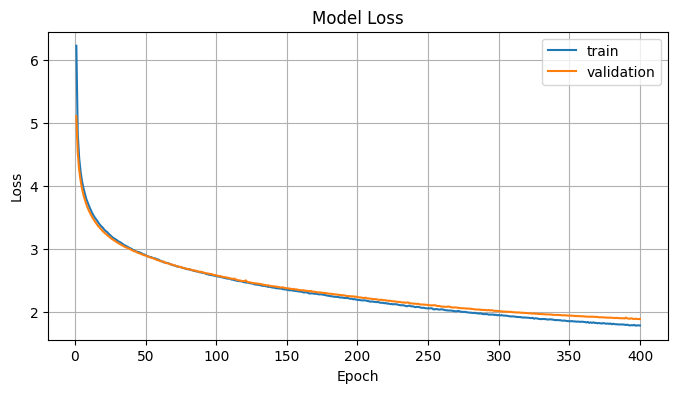

In [ ]:
plot_losses(train_losses, validation_losses)

true: interstitial markings are diffusely prominent throughout both lungs. heart size is normal. pulmonary xxxx normal. diffuse fibrosis. no visible focal acute disease.
guess: anticipated xxxx chondral granulomas superior arthritis some proximal hepatic reference indeterminant pneumomediastinum overt recently bronchi foreign now helpful anticipated dimension correlate bronchitic foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now helpful anticipated dimension correlate ng foreign now 

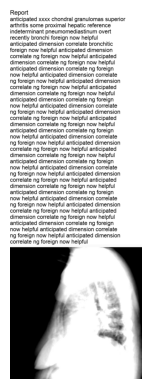

In [55]:
sample_idx = 10
xray, report_ids, _ = train_dataset[sample_idx]

target = [id2token(token) for token in report_ids[1:-1]]
generated = model.sample(xray, token2id, id2token)

report = tokens_to_text(target)
report_est = tokens_to_text(generated)

print(f"true: {report}")
print(f"guess: {report_est}")

xray_plotable = xray[0].numpy()
plot_text_and_image(report_est, "Report", xray_plotable)

## Misc

In [56]:
out = model(torch.tensor(report_ids)[None], xray[None])
token_ids = out.argmax(dim=-1)

tokens = [id2token(id.item()) for id in token_ids[0]]
tokens_to_text(tokens)

'anticipated carcinoma doctor will overt beneath x excluded br due placed interval acute computed due prevertebral doctor computed due top first due spur foreign placed infracarinal remarkable due mentally'

In [57]:
model.decoder.decoder_layer.sa_weights.shape

torch.Size([1, 29, 29])

In [58]:
model.decoder.decoder_layer.mha_weights.shape

torch.Size([1, 29, 197])

In [81]:
attention_weights_tokens = model.decoder.decoder_layer.mha_weights[0].detach().numpy()
attention_weights_tokens.shape

(29, 197)

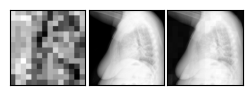

In [93]:
image_attention_mask = create_avg_image_attention_mask(attention_weights_tokens[:,1:], xray_plotable.shape, (14, 14))
image_attention = np.array([image_attention_mask, xray_plotable, image_attention_mask * xray_plotable])
plot_images(image_attention)